In [53]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings(action='ignore')


In [57]:
image_dir = Path('../input/boat-types-recognition')


In [58]:

image_files = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], image_files))
image_df = pd.DataFrame({'Filepath': image_files, 'Label': labels}).astype(str).sample(frac=1.0, random_state=1).reset_index(drop=True)
image_df

,Filepath,Label
0,../input/boat-types-recognition/gondola/venice...,gondola
1,../input/boat-types-recognition/kayak/canoe-wa...,kayak
2,../input/boat-types-recognition/paper boat/shi...,paper boat
3,../input/boat-types-recognition/kayak/lake-isl...,kayak
4,../input/boat-types-recognition/gondola/venice...,gondola
...,...,...
2919,../input/boat-types-recognition/sailboat/natur...,sailboat
2920,../input/boat-types-recognition/kayak/action-a...,kayak
2921,../input/boat-types-recognition/boats/gondola/...,gondola
2922,../input/boat-types-recognition/gondola/gondol...,gondola


In [59]:
image_df['Label'].value_counts()

sailboat           976
kayak              508
gondola            484
cruise ship        478
ferry boat         162
buoy               136
paper boat          80
freight boat        58
inflatable boat     42
Name: Label, dtype: int64

In [60]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [61]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [63]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False)

Found 2046 validated image filenames belonging to 9 classes.
Found 2046 validated image filenames belonging to 9 classes.
Found 878 validated image filenames belonging to 9 classes.


In [64]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_images,validation_data=val_images, epochs=100,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)])


Epoch 1/100
64/64 [==============================] - 86s 1s/step - loss: 1.9523 - accuracy: 0.3145 - val_loss: 1.7880 - val_accuracy: 0.3372
Epoch 2/100
64/64 [==============================] - 85s 1s/step - loss: 1.7692 - accuracy: 0.3310 - val_loss: 1.7248 - val_accuracy: 0.3397
Epoch 3/100
64/64 [==============================] - 84s 1s/step - loss: 1.7226 - accuracy: 0.3347 - val_loss: 1.7164 - val_accuracy: 0.3539
Epoch 4/100
64/64 [==============================] - 84s 1s/step - loss: 1.6858 - accuracy: 0.3511 - val_loss: 1.6786 - val_accuracy: 0.3734
Epoch 5/100
64/64 [==============================] - 86s 1s/step - loss: 1.6972 - accuracy: 0.3631 - val_loss: 1.6615 - val_accuracy: 0.3583
Epoch 6/100
64/64 [==============================] - 86s 1s/step - loss: 1.7074 - accuracy: 0.3536 - val_loss: 1.6531 - val_accuracy: 0.3768
Epoch 7/100
64/64 [==============================] - 86s 1s/step - loss: 1.6517 - accuracy: 0.3642 - val_loss: 1.6015 - val_accuracy: 0.3905
Epoch 8/100
6

In [74]:
model.summary()
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224

In [72]:
acc = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']

Text(0.5, 1.0, 'MODEL ACCURACY')

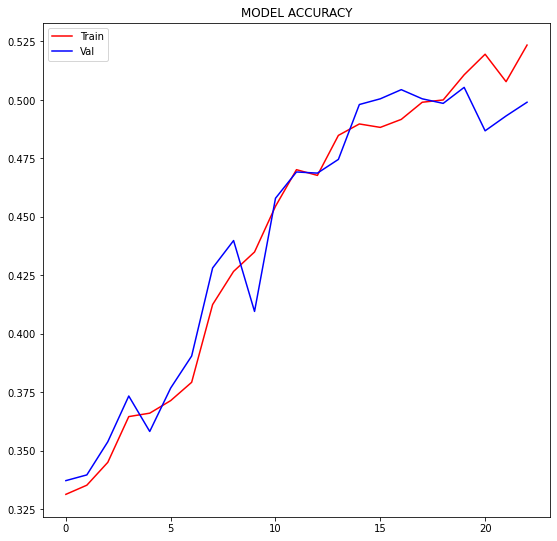

In [81]:
epochs_range = range(23)
plt.figure(figsize=(20, 20))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc,'r', label='Train')
plt.plot(epochs_range, validation_accuracy,'b' ,label='Val')
plt.legend(loc='upper left')
plt.title('MODEL ACCURACY')

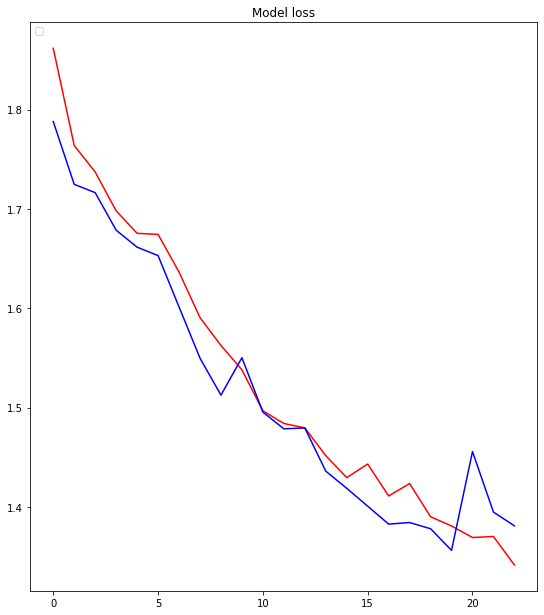

In [82]:
plt.figure(figsize=(20, 23))
plt.subplot(2, 2, 1)
plt.legend(loc='upper left')
plt.title('Model loss')
plt.plot(epochs_range, loss,'r', label='Train')
plt.plot(epochs_range, validation_loss,'b' ,label='Val')



In [77]:
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.46834
Test Accuracy: 50.57%


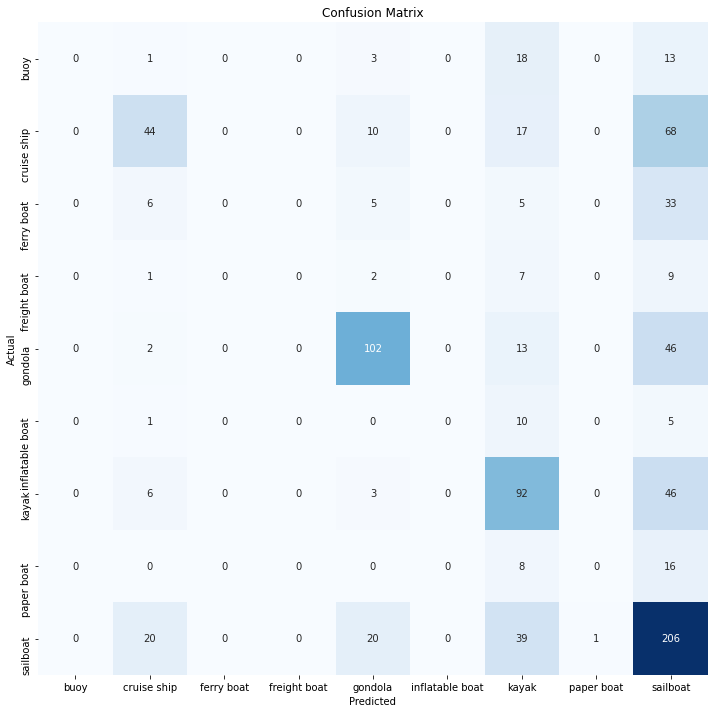

Classification Report:
----------------------
                  precision    recall  f1-score   support

           buoy       0.00      0.00      0.00        35
    cruise ship       0.54      0.32      0.40       139
     ferry boat       0.00      0.00      0.00        49
   freight boat       0.00      0.00      0.00        19
        gondola       0.70      0.63      0.66       163
inflatable boat       0.00      0.00      0.00        16
          kayak       0.44      0.63      0.52       147
     paper boat       0.00      0.00      0.00        24
       sailboat       0.47      0.72      0.57       286

       accuracy                           0.51       878
      macro avg       0.24      0.25      0.24       878
   weighted avg       0.44      0.51      0.46       878



In [80]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=list(train_images.class_indices.keys()))

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.yticks(ticks=np.arange(9) + 0.5, labels=list(train_images.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)
